In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


# 📊 E-Commerce Sales Analysis and Customer Insights

This notebook analyzes UK E-Commerce transactions (2010–2011).  
It covers:
- Data cleaning & preprocessing  
- Exploratory Data Analysis (EDA) with sales & customer trends  
- RFM (Recency, Frequency, Monetary) analysis  
- Customer segmentation using clustering  

✅ Goal: To identify customer purchase behavior and actionable insights for business growth.


**Import Libraries & Loading Data Set**

In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset 
file_path = "/kaggle/input/ecommerce-data/data.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Data Set Overview**

In [3]:
# Shape of dataset
print("Rows:", df.shape[0], "Columns:", df.shape[1])

# Info about columns
df.info()

# Summary stats
df.describe()


Rows: 541909 Columns: 8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**Data Cleaning**

In [4]:
# Check missing values
df.isnull().sum()

# Drop rows with missing CustomerID (important for customer analysis)
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalAmount = Quantity × UnitPrice
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Final check
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


**Exploratory Data Analysis (EDA)**

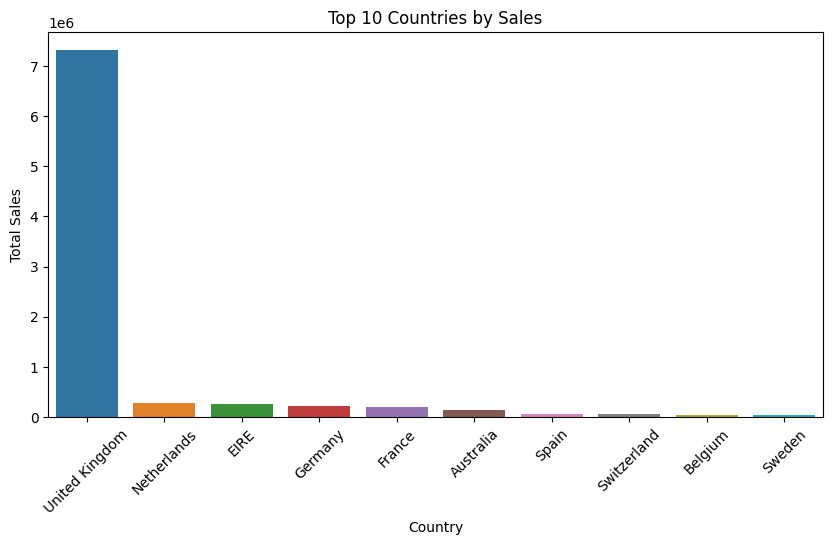

/tmp/ipykernel_13/2873199360.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['TotalAmount'].resample('M').sum()


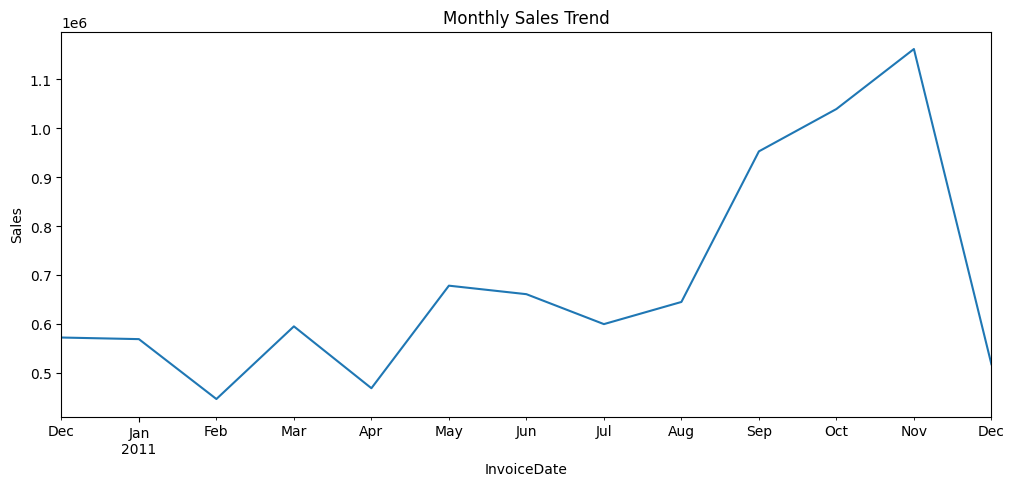

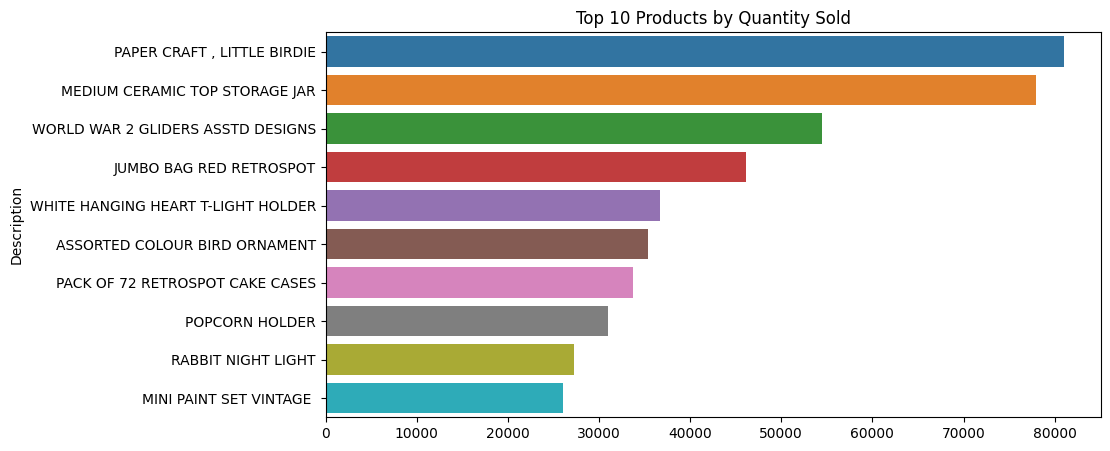

In [5]:
# Sales by Country
country_sales = df.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=country_sales.index, y=country_sales.values)
plt.title("Top 10 Countries by Sales")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

# Monthly sales trend
df.set_index('InvoiceDate', inplace=True)
monthly_sales = df['TotalAmount'].resample('M').sum()

plt.figure(figsize=(12,5))
monthly_sales.plot()
plt.title("Monthly Sales Trend")
plt.ylabel("Sales")
plt.show()

# Top 10 products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(y=top_products.index, x=top_products.values)
plt.title("Top 10 Products by Quantity Sold")
plt.show()


**RFM Analysis**

In [6]:
# Reset index (because we set InvoiceDate earlier)
df = df.reset_index()

# Today's date for Recency calculation
import datetime as dt
NOW = df['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM Table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,  # Recency
    'InvoiceNo': 'count',                          # Frequency
    'TotalAmount': 'sum'                           # Monetary
})

rfm.rename(columns={'InvoiceDate':'Recency',
                    'InvoiceNo':'Frequency',
                    'TotalAmount':'Monetary'}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


**Clustering Customers (K-Means)**

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

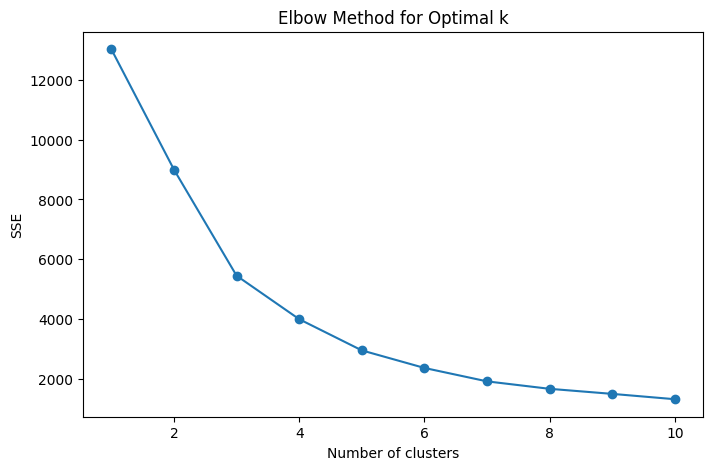

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,1
12347.0,2,182,4310.00,0
12348.0,75,31,1797.24,0
12349.0,19,73,1757.55,0
12350.0,310,17,334.40,1


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Find optimal clusters (Elbow Method)
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(8,5))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.show()

# Fit KMeans with optimal k (say 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()


**Visualize Clusters**

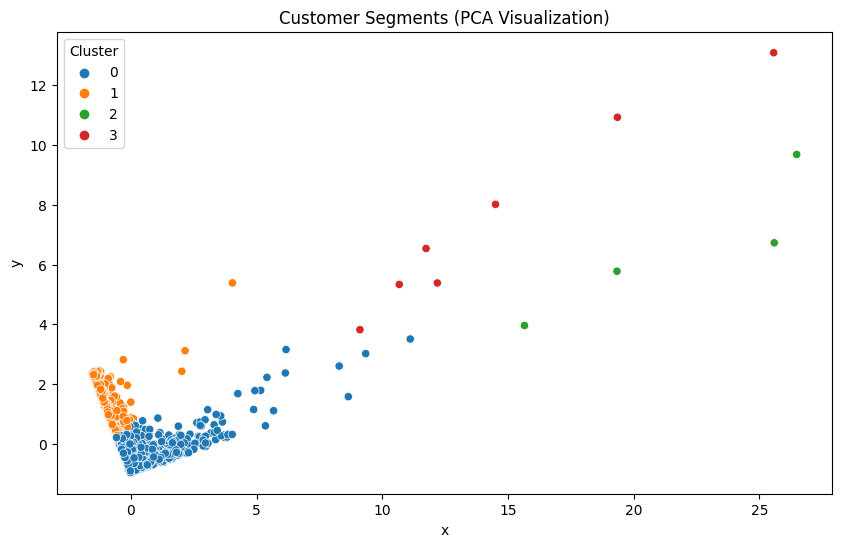

In [8]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['x'] = rfm_pca[:,0]
rfm['y'] = rfm_pca[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='x', y='y', hue='Cluster', palette='tab10')
plt.title("Customer Segments (PCA Visualization)")
plt.show()


# Insights & Recommendations

### 🔹 Cluster 0: VIP Customers
- High Frequency, High Monetary, Low Recency.
- These customers buy often, spend a lot, and purchased recently.
- **Recommendation:** Give loyalty rewards, early access to new products.

### 🔹 Cluster 1: At-Risk Customers
- High Recency, Low Frequency, Low Monetary.
- These customers haven’t purchased in a long time.
- **Recommendation:** Send discount offers, personalized emails to bring them back.

### 🔹 Cluster 2: Low-Value Customers
- Low Frequency, Low Monetary.
- Spend less and buy rarely.
- **Recommendation:** Minimal marketing effort, push budget-friendly offers.

### 🔹 Cluster 3: Regular Customers
- Moderate Recency, Frequency, and Monetary.
- Stable buyers, potential to grow.
- **Recommendation:** Upsell and cross-sell products, convert into VIPs.
